In [1]:
# !python parallelosaurus.py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl
import glob

In [3]:
df_master = pd.read_csv("minisaurus_net_test_lim.csv").fillna(0).drop(columns=['model_number', 'gyre_fn', 'num_zones', 
                                                                    'priority','star_age', 'num_retries','num_iters'])
cols = ['m', 'z', 'v', 'density', 'log_Teff', 'tr_num', 'Myr', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0', 'n5ell0m0',
       'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0', 'n1ell1m0',
       'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0', 'n7ell1m0',
       'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'Dnu', 'eps', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']
df_master = df_master[cols]
df_master.columns

Index(['m', 'z', 'v', 'density', 'log_Teff', 'tr_num', 'Myr', 'n1ell0m0',
       'n2ell0m0', 'n3ell0m0', 'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0',
       'n8ell0m0', 'n9ell0m0', 'n10ell0m0', 'n1ell1m0', 'n2ell1m0', 'n3ell1m0',
       'n4ell1m0', 'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0',
       'n10ell1m0', 'Dnu', 'eps', 'n1ell1dfreq', 'n2ell1dfreq', 'n3ell1dfreq',
       'n4ell1dfreq', 'n5ell1dfreq', 'n6ell1dfreq', 'n7ell1dfreq',
       'n8ell1dfreq', 'n9ell1dfreq', 'n10ell1dfreq'],
      dtype='object')

In [ ]:
hist = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/history.data", skiprows=5, delim_whitespace=True)
profile_index = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profiles.index", skiprows=1, 
                            names=['model_number', 'priority', 'profile_number'], delim_whitespace=True)

profiles = []
ages = []
old = 0
for i, row in hist.iterrows():
    age = row.star_age/1e6
    new = int(age) + int(age * 10) % 10
    hist_model = row.model_number
    profile_model = profile_index.query(f"model_number=={row.model_number}").model_number.values
    if len(profile_model) !=0:
        profile_model = profile_model[0]
        if hist_model == profile_model:
            profile_number = profile_index.query(f"model_number=={row.model_number}").profile_number.values[0]
            if new > old:
                ages.append(new)
                profiles.append(pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profile{profile_number}.data", 
                                            skiprows=5, delim_whitespace=True))
                old = new

In [4]:
def plot_2d(args):
    plt.cla()
    age, profile = args
    palette = sns.color_palette("flare", len(profile))
    theta = np.linspace(0, 2*np.pi, 100)  # 100 points evenly spaced from 0 to 2*pi
    radius_max = 10**profile.logR.max()
    densities = 10**profile.logRho.sort_values()
    for i, row in profile.iterrows():
        radius = 10**row.logR
        # Convert 1D values to 2D Cartesian coordinates
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        di = np.where(densities == 10**row.logRho)[0][0]
        plt.plot(x, y, lw=1, color=palette[di])
    r = 5
    plt.xlim(-r, r)
    plt.ylim(-r, r)
    plt.title(f"Age: {age} Myr")


In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

fig = plt.figure(figsize=(6, 6))
ani = FuncAnimation(fig, plot_2d, frames=zip(ages, profiles))

NameError: name 'plot_2d' is not defined

<Figure size 600x600 with 0 Axes>

In [14]:
writer = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264', '-preset', 'slow', '-crf', '18'])
ani.save(f'figures/2d.mp4', writer=writer)

MovieWriter ffmpeg unavailable; using Pillow instead.


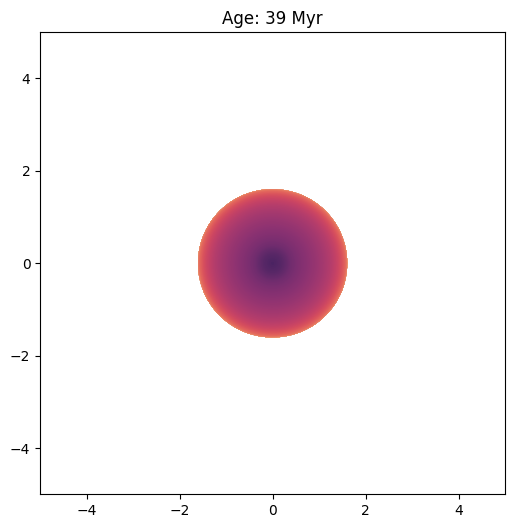

In [37]:
import time
from IPython import display

with plt.ion():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    for i, profile in enumerate(profiles):
        try:
            palette = sns.color_palette("flare", len(profile))
            args = ages[i], profile
            plot_2d(args)
            # plt.colorbar(10**profile.logRho, label='Density')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            # time.sleep(0.1)
        except KeyboardInterrupt:
            break

In [4]:
ref = 3
# ages_t = np.arange(df_master[df_master.tr_num == ref].Myr.values[0], 1500, 0.1)


dfs = []
age_lists = []
for tr_num in range(5):
    this_df = df_master[df_master.tr_num == tr_num]
    this_df = this_df.sort_values(by='Myr').reset_index()
    new_df = pd.DataFrame()
    new_df['Myr'] = np.arange(5, 500, 0.1)
    for col in this_df.columns:
        if col not in ['index', 'Myr', 'tr_num', 'm', 'v', 'z']:
            f = interp1d(this_df["Myr"], this_df[col], kind='slinear', fill_value='extrapolate')
            new_df[col] = f(new_df['Myr'])
    dfs.append(new_df)


# dfs = []
# for tr_num in range(5):
#     this_df = df[df.tr_num == tr_num]
#     dfs.append(this_df.sort_values(by='Myr').reset_index())


In [29]:
cols0 = ['n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0']

cols1 = ['n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0',
         'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0']

ref = 3
df_ref = dfs[ref]
# param_samples = np.round(np.append(np.arange(0.1, 1.4, 0.3), [1.25]), 3)
# print("ref param: ", param_samples[ref])
mean_diffs = []
ages = []


for this_df in dfs:
    this_mean = []
    age = []
    for i, row in df_ref.iterrows():
        freqs_ref_0 = row[cols0]
        freqs_ref_1 = row[cols1]
        freqs_alt_0 = this_df.iloc[i][cols0]
        freqs_alt_1 = this_df.iloc[i][cols1]
        diff_0 = ((freqs_alt_0 - freqs_ref_0)/freqs_ref_0).fillna(0)
        diff_1 = ((freqs_alt_1 - freqs_ref_1)/freqs_ref_1).fillna(0)
        this_mean.append(np.mean( np.append(diff_0, diff_1) ))
        age.append(row["Myr"])
        if row["Myr"] > 40:
            break
    ages.append(age)
    mean_diffs.append(this_mean)

In [603]:
diffs_save = np.array(mean_diffs)

In [604]:
# from scipy.signal import savgol_filter as filter
from scipy.signal import medfilt as filter
diffs = []
for i, mean_diff in enumerate(diffs_save):
    diffs.append(filter(mean_diff, 5))
mean_diffs = diffs

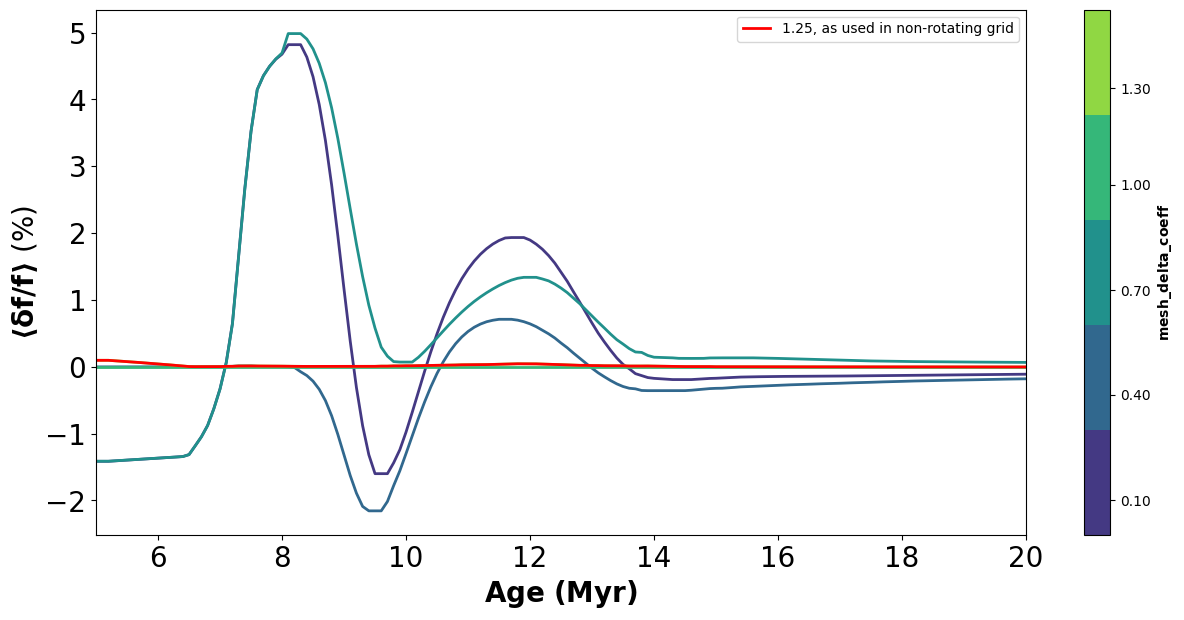

In [605]:
fig = plt.figure(figsize=(15, 15))
palette = sns.color_palette("viridis", len(dfs))
# palette = sns.color_palette("colorblind", len(var_samples))
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


ax1 = plt.subplot(2, 1, 1)
for ind, df in enumerate(dfs):
    plt.plot(ages[ind], 100*np.array(mean_diffs[ind]), color=palette[ind], lw=2)
plt.plot(ages[-1], 100*np.array(mean_diffs[-1]), lw=2, color='red', label=f'1.25, as used in non-rotating grid')
plt.legend(loc='upper right')

title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([5, 20])
# plt.ylim([-0.3, 0.8])
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
# rect = mpl.patches.Rectangle((15, -0.001), 20, 0.004, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
# ax1.add_patch(rect)


# ax2 = plt.subplot(2, 1, 2)
# for ind, var in enumerate(var_samples):
#     # plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2, linestyle=linestyle_tuple[ind][1])
#     plt.plot(ages[ind], mean_diffs[ind], color=palette[ind], lw=2)
# plt.plot(ages[-1], mean_diffs[-1], lw=2, color='red')
# plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
# plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
# plt.gca().xaxis.set_tick_params(labelsize=20)
# plt.gca().yaxis.set_tick_params(labelsize=20)
# plt.xlim([20, 500])
# plt.ylim([-0.01, 0.03])
# plt.subplots_adjust(wspace=0, hspace=0.3)


param_samples = np.arange(0.1, 1.4, 0.3)
Z = [[0,0],[0,0]]
levels = np.array(sorted(param_samples)+[1.7])
contour = plt.contourf(Z, levels, cmap=mpl.colors.ListedColormap(palette))
axes = [ax1]
cb = plt.colorbar(contour, ticks=levels+0.1, label=r'$\bf{mesh\_delta\_coeff}$', ax=axes)
cb.set_ticklabels([f"{level:.2f}" for level in levels])

# ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))

fig.align_ylabels([ax1])
plt.show()
# plt.savefig(f'../figures/mean_diff_panels.pdf', dpi=300, bbox_inches='tight')

In [634]:
dfs[0].columns

Index(['Myr', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0', 'n5ell0m0',
       'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0', 'n1ell1m0',
       'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0', 'n7ell1m0',
       'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'Dnu', 'eps', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq'],
      dtype='object')

In [26]:
from sklearn.tree import DecisionTreeRegressor
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.neural_network import MLPRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.signal import medfilt 
from scipy.signal import savgol_filter 
from scipy.signal import symiirorder1
from scipy.signal import symiirorder2
from scipy.signal import wiener

from scipy.interpolate import UnivariateSpline
from scipy import stats

cols0 = ['n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0']

cols1 = ['n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0',
         'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0']

def get_mean_rel_err(df, ref_df, cols0, cols1):
    mean_rel_err = []
    age = []
    for i, row in ref_df.iterrows():
        t = row["Myr"]
        freqs_ref_0 = row[cols0]
        freqs_ref_1 = row[cols1]
        freqs_alt_0 = df.query(f"Myr=={t}")[cols0]
        freqs_alt_1 = df.query(f"Myr=={t}")[cols1]
        diff_0 = ((freqs_alt_0 - freqs_ref_0)/freqs_ref_0).fillna(0)
        diff_1 = ((freqs_alt_1 - freqs_ref_1)/freqs_ref_1).fillna(0)
        mean_rel_err.append(np.mean(np.append(diff_0, diff_1)))
        age.append(row["Myr"])
    mean_rel_err = medfilt(mean_rel_err, kernel_size=5)
    return mean_rel_err, age



def age_uncertainty(df, ref_df, cols0, cols1):
    df = df.query("Myr < 40")
    ref_df = ref_df.query("Myr < 40")
    mean_rel_err, age = get_mean_rel_err(df, ref_df, cols0, cols1)
    mean_rel_err = np.array(mean_rel_err)
    true_age = np.array(age)
    # true_dnu = ref_df["Dnu"].values
    # true_cols0 = ref_df[cols0].values
    # true_cols1 = ref_df[cols1].values
    true_dnu = df["Dnu"].values
    # other_cols = df[['density', 'eps']].values
    other_cols = df[cols0+cols1].values


    # idx_zero_cross = list(np.where(np.diff(np.signbit(np.diff(true_dnu))))[0])
    # idx_zero_cross = sorted([np.argmin(true_dnu), np.argmax(true_dnu)])
    # idx_zero_cross = sorted(np.append(argrelextrema(true_dnu, np.less)[0], argrelextrema(true_dnu, np.greater)[0]))
    # idx_zero_cross = []
    x = 50
    idx_zero_cross = list(np.arange(x, len(true_dnu)-x, x))

    idxs = [0] + idx_zero_cross + [len(true_dnu)-1]
    # print(len(idxs), idxs)
    Xs = [[] for i in range(len(idxs)-1)]
    Ys = [[] for i in range(len(idxs)-1)]
    regrs = []
    for i in range(1, len(idxs)):
        Xs[i-1] = np.column_stack((true_dnu[idxs[i-1]:idxs[i]], other_cols[idxs[i-1]:idxs[i]]))
        Ys[i-1] = true_age[idxs[i-1]:idxs[i]]
        regrs.append(DecisionTreeRegressor(max_depth=1111, random_state=0).fit(Xs[i-1], Ys[i-1]))
    
    Dnus = []
    preds = []
    mean_rel_err = np.array([err if err != np.inf and err != -np.inf else 0 for err in mean_rel_err])
    for i in range(1, len(idxs)):
        Dnus.append( np.column_stack((true_dnu[idxs[i-1]:idxs[i]]*(1+mean_rel_err[idxs[i-1]:idxs[i]]),
                                        other_cols[idxs[i-1]:idxs[i]]*(1+mean_rel_err[idxs[i-1]:idxs[i], np.newaxis]))))
        preds.append(regrs[i-1].predict(Dnus[i-1]))
    predicted_age = np.concatenate(preds)
    age_rel_err = [(pred - true)/true for pred, true in zip(predicted_age, true_age)]
    
    # Test the fit
    Y_test = true_age[:-1]
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, predicted_age))
    print('R2 Variance score: %.2f' % r2_score(Y_test, predicted_age))
    
    # plt.plot(Y_test, predicted_age, 'o', color='black')
    # plt.plot(Y_test, Y_test, color='red')
    return age_rel_err, predicted_age, Y_test

# def find_nearest(arr, val):
#     arr = np.asarray(arr)
#     idx = (np.abs(arr - val)).argmin()
#     return arr[idx], idx

# def age_uncertainty(df, ref_df, cols0, cols1):
#     df = df.query("Myr < 40")
#     ref_df = ref_df.query("Myr < 40")
#     mean_rel_err, age = get_mean_rel_err(df, ref_df, cols0, cols1)
#     mean_rel_err = np.array(mean_rel_err)
#     true_age = np.array(age)
#     # true_dnu = ref_df["Dnu"].values
#     # true_cols0 = ref_df[cols0].values
#     # true_cols1 = ref_df[cols1].values
#     true_dnu = df["Dnu"].values

#     f = interp1d(true_age, true_dnu, kind="cubic", fill_value="extrapolate")
#     fine_age = np.arange(age[0], age[-1], 0.0001)
#     fine_dnu = f(fine_age)

#     mean_rel_err = np.array([err if err != np.inf and err != -np.inf else 0 for err in mean_rel_err])
#     Dnus = true_dnu*(1+mean_rel_err)
#     preds = []
#     for i, dnu in enumerate(Dnus):
#         val, idx = find_nearest(fine_dnu[i:], dnu)
#         preds.append(fine_age[idx])
#     age_rel_err = [(pred - true)/true for pred, true in zip(preds, true_age)]
#     return age_rel_err, preds, true_age

Mean squared error: 4.98
R2 Variance score: 0.95


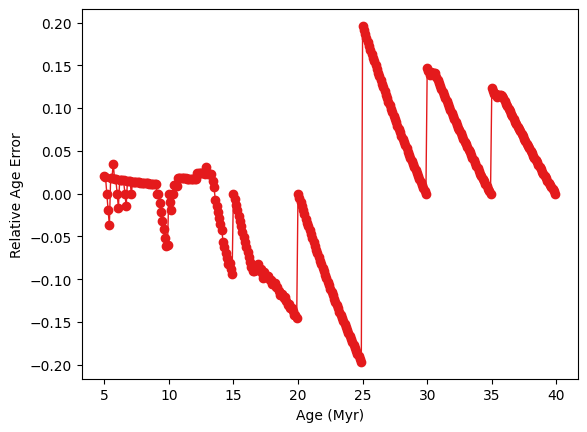

Mean squared error: 5.28
R2 Variance score: 0.95


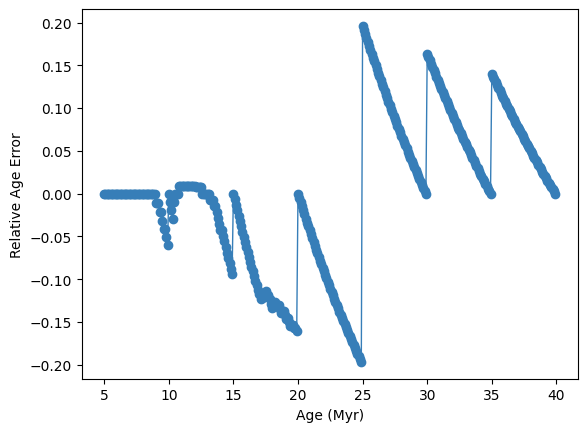

Mean squared error: 2.67
R2 Variance score: 0.97


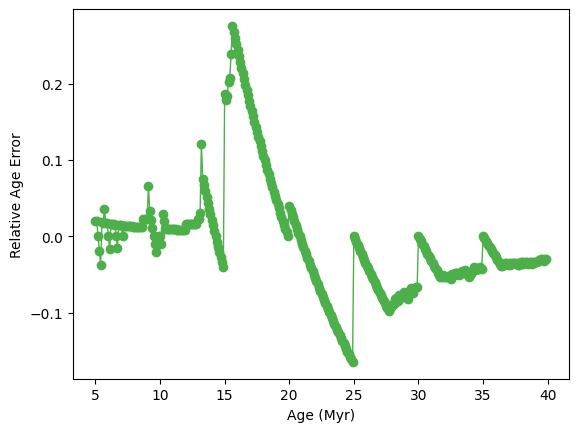

Mean squared error: 0.00
R2 Variance score: 1.00


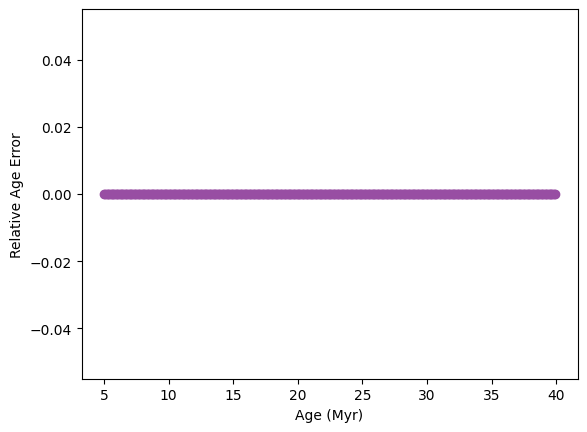

Mean squared error: 0.40
R2 Variance score: 1.00


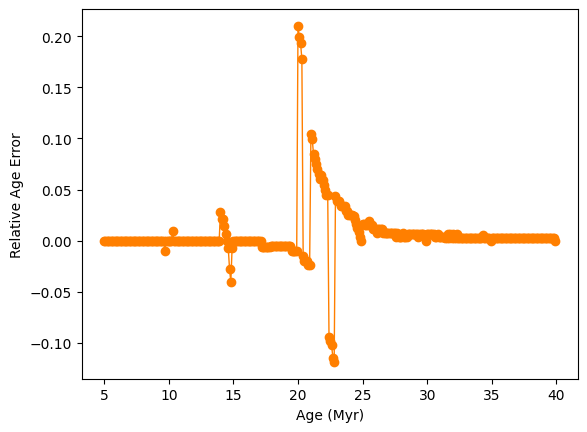

In [27]:
palette = plt.get_cmap('Set1')
age_rel_errs = []
for i, df in enumerate(dfs):
    age_rel_err, predicted_age, true_age = age_uncertainty(df, dfs[3], cols0, cols1)
    age_rel_errs.append(age_rel_err)
    plt.plot(true_age, age_rel_err, '-o', lw=1, color=palette(i))
    plt.xlabel("Age (Myr)")
    plt.ylabel("Relative Age Error")
    plt.show()

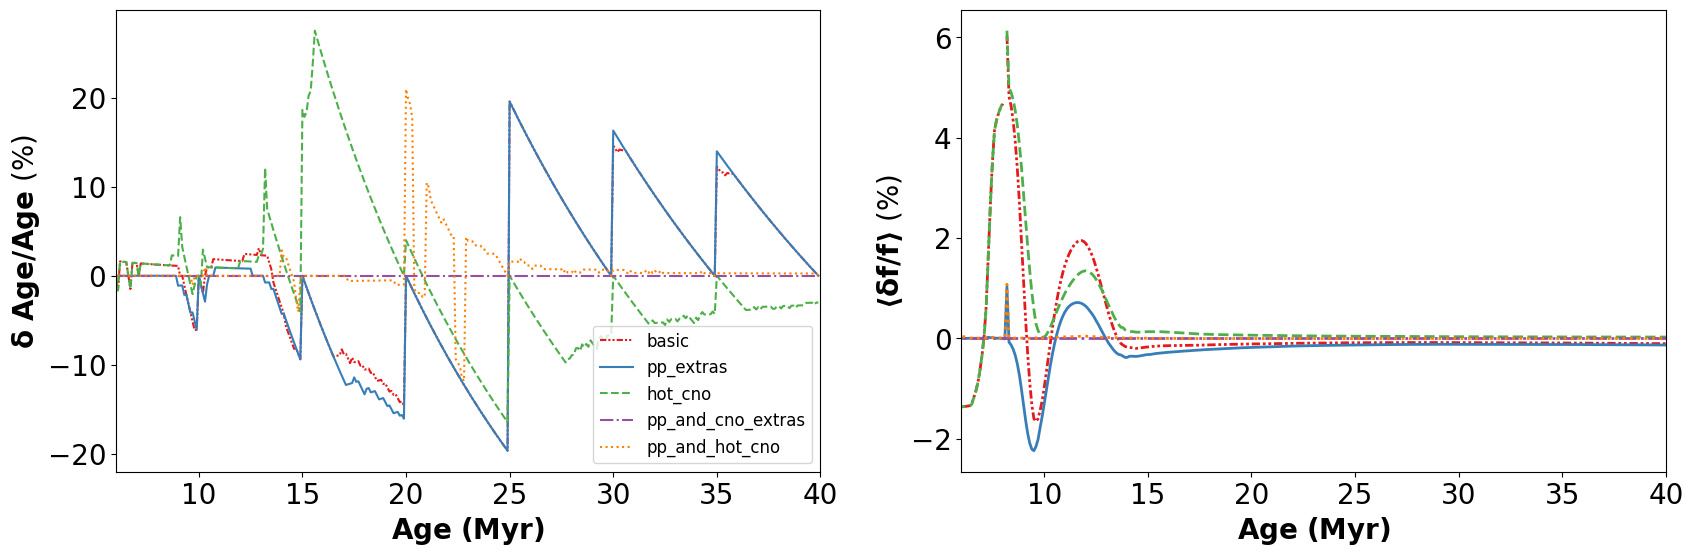

In [30]:
params = ["basic", "pp_extras", "hot_cno", "pp_and_cno_extras", "pp_and_hot_cno"]
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("Set1", 5)

plt.figure(figsize=(20, 6))
age = true_age
plt.subplot(1, 2, 1)
for i, age_rel_err in enumerate(age_rel_errs):
    plt.plot(age, 100*np.array(age_rel_err), color=palette[i], label=params[i], linestyle=linestyle_tuple[i])
plt.xlabel("Age (Myr)")
plt.ylabel("Relative Age Error")
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\delta\ Age/Age}\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
plt.legend(prop={'size': 12})
plt.xlim(6, 40)


plt.subplot(1, 2, 2)
for ind, df in enumerate(dfs):
    plt.plot(ages[ind], 100*np.array(mean_diffs[ind]), color=palette[ind], linestyle=linestyle_tuple[ind], lw=2)
title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([6, 40])

plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)


# plt.savefig("age_uncertainty.png", dpi=300)
plt.show()

(6.0, 40.0)

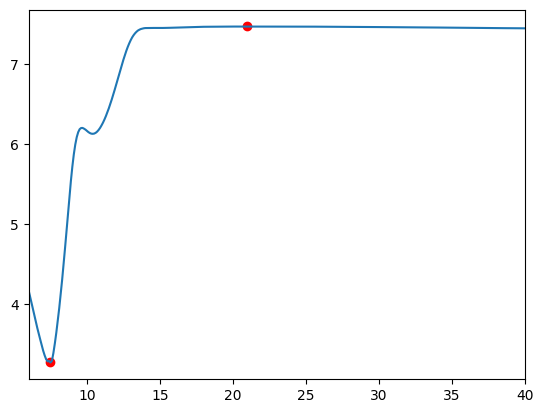

In [406]:
plt.plot(dfs[3]["Myr"], dfs[3]["Dnu"])
arg = np.argmax(dfs[3]["Dnu"])
plt.scatter(dfs[3]["Myr"].iloc[arg], dfs[3]["Dnu"].iloc[arg], color='red')
arg = np.argmin(dfs[3]["Dnu"])
plt.scatter(dfs[3]["Myr"].iloc[arg], dfs[3]["Dnu"].iloc[arg], color='red')
plt.xlim(6, 40)